# 0 Imports and helper functions

https://gallery.azure.ai/Experiment/837e2095ce784f1ba5ac623a60232027

In [0]:
import sklearn
import pandas as pd
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import roc_curve, auc
import json

%matplotlib inline

# 1 Loading the data

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')


In [0]:
# delays = pd.read_csv("/content/drive/My Drive/xylosai/regression/FlightDelaysData.csv",header=0)

In [0]:
# weather = pd.read_csv("/content/drive/My Drive/xylosai/regression/WeatherDataset.csv",header=0)

In [8]:

delays = pd.read_csv("/content/drive/My Drive/xylosai/regression/FlightDelaysData.csv",header=0)
weather = pd.read_csv("/content/drive/My Drive/xylosai/regression/WeatherDataset.csv",header=0)

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# delays = pd.read_csv("FlightDelaysData.csv",header=0)
# weather = pd.read_csv("WeatherDataset.csv",header=0)

In [10]:
delays.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0.0,0.0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0.0,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0.0,0.0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1.0,0.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0.0,0.0


In [11]:
delays.dtypes

Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
Carrier             object
OriginAirportID      int64
DestAirportID        int64
CRSDepTime           int64
DepDelay           float64
DepDel15           float64
CRSArrTime           int64
ArrDelay           float64
ArrDel15           float64
Cancelled          float64
dtype: object

# 2 Cleaning weather data

## 2.1 Exploring the weather data

Pandas provides some native exploration methods that can be called on a dataframe. we will use describe() and plot(). 

 1. [describe()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html) provides basic statistics for every column. The output is another dataframe.
 2. [plot()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) is used to plot column data. By default it creates a line plot, but different plots are possible (see docs). It only plots numerical data. For visualizing categorical data, we will use value_counts() on a column first (see below).

In [12]:
weather.head()

,AirportID,Year,Month,Day,Time,TimeZone,SkyCondition,Visibility,WeatherType,DryBulbFarenheit,...,WindSpeed,WindDirection,ValueForWindCharacter,StationPressure,PressureTendency,PressureChange,SeaLevelPressure,RecordType,HourlyPrecip,Altimeter
0,14843,2013,4,1,56,-4,FEW018 SCT044 BKN070,10.00,-RA,76,...,13,080,,30.06,,,30.06,AA,T,30.07
1,14843,2013,4,1,156,-4,FEW037 SCT070,10.00,,76,...,10,090,,30.05,6,017,30.05,AA,,30.06
2,14843,2013,4,1,256,-4,FEW037 SCT070,10.00,,76,...,9,100,,30.03,,,30.03,AA,,30.04
3,14843,2013,4,1,356,-4,FEW025 SCT070,10.00,,76,...,9,100,,30.02,,,30.03,AA,,30.03
4,14843,2013,4,1,456,-4,FEW025,10.00,,76,...,7,110,,30.03,5,004,30.04,AA,,30.04


Display a list of all columns with their dtypes.

In [13]:
weather.dtypes

AirportID                 int64
Year                      int64
Month                     int64
Day                       int64
Time                      int64
TimeZone                  int64
SkyCondition             object
Visibility               object
WeatherType              object
DryBulbFarenheit         object
DryBulbCelsius           object
WetBulbFarenheit         object
WetBulbCelsius           object
DewPointFarenheit        object
DewPointCelsius          object
RelativeHumidity         object
WindSpeed                object
WindDirection            object
ValueForWindCharacter    object
StationPressure          object
PressureTendency         object
PressureChange           object
SeaLevelPressure         object
RecordType               object
HourlyPrecip             object
Altimeter                object
dtype: object

In [14]:
weather.describe()

,AirportID,Year,Month,Day,Time,TimeZone
count,406516.000000,406516.0,406516.000000,406516.000000,406516.000000,406516.000000
mean,13046.619513,2013.0,6.978857,15.730847,1183.907057,-6.096933
std,1528.710954,0.0,2.001600,8.848019,688.247431,1.368397
min,10140.000000,2013.0,4.000000,1.000000,0.000000,-10.000000
25%,11618.000000,2013.0,5.000000,8.000000,556.000000,-7.000000
50%,13342.000000,2013.0,7.000000,16.000000,1153.000000,-6.000000
75%,14307.000000,2013.0,9.000000,23.000000,1753.000000,-5.000000
max,15376.000000,2013.0,10.000000,31.000000,2359.000000,-4.000000


From the table above, we conclude that all the data is from the **Year** 2013. There are **406 516 records** in total. (you can also check this with *len(weather)*)

## 2.1 Dropping columns with lots of empty strings

Print the unique values of  **ValueForWindCharacter**. Notice the empty string.

In [15]:
weather["ValueForWindCharacter"].unique()

array([' ', '21', '23', '24', '25', '26', '28', '18', '22', '20', '32',
       '29', '17', '16', '30', '31', '37', '40', '38', '39', '36', '34',
       '43', '33', '49', '59', '47', '44', '41', '46', '56', '53', '48',
       '45', '54', '51', '55', '52', '70', '71', '68', '14', '61', '60',
       '67', '58', '69', '66', '89', '64', '74'], dtype=object)

How many (as a percentage) of the ValueForWindCharacter values are empty strings?

In [16]:
perc = float(weather[weather["ValueForWindCharacter"] == ' ']["ValueForWindCharacter"].count())/len(weather)
print(perc)

0.878186836434


Let's do the same for **PressureTendency, WeatherType, PressureChange** and **HourlyPrecip**

In [17]:
weather["PressureTendency"].unique()

array([' ', '6', '5', '3', '1', '8', '0', '2', '7', '4'], dtype=object)

In [18]:
perc = float(weather[weather["PressureTendency"] == ' ']["PressureTendency"].count())/len(weather)
print(perc)

0.960660834998


In [19]:
weather["WeatherType"].unique()

array(['-RA', ' ', '+RA BR', 'RA BR', '-RA BR', 'RA', '+RA', 'TSRA',
       '-TSRA BR', '-TSRA', '-DZ BR', 'BCFG', '+TSRA FG', 'BR', 'FG',
       'BR BCFG', 'VCFG', 'FU BR', '+TSRA BR', 'TSRA BR', 'MIFG', 'TS',
       '+TSRA', '+RA FG', '-TSRA SQ', '+FC -RA', '+FC', 'VCTS RA BR',
       'VCTS', 'VCTS -RA', 'HZ', '-DZ', 'MIFG BR', 'DZ BR', '+TS RAGS BR',
       '+TS RAGR BR', '+TS GSRA FG', '+TS GSRA BR', 'TS BR', '-PLRA',
       '-RAPL', '+TSRA BR SQ', 'BCFG BR', '+DZ FG', '+DZ', 'SQ', '-DZ FG',
       '+TSRA SQ', 'FG BR', 'TS RAGS', 'TS RAGR', '-DZ HZ', 'TS FZRA',
       'TS -FZRA', '-FZRA', '-FZRA BR', 'FZRA BR', '-SN BR', '-FZRAPL BR',
       'TS HZ', '-SN', '-RA FG', '-RASN', 'RA BR FU', '-TSRA BR SQ',
       '-RAGS', 'UP BR', 'RAPL BR', '-TSSN', 'SN FZFG', '-PLUP',
       '-PL SNRA', '-FZRASN', '-FZRASN BR', 'SN FG', '+SN FG', '-TSSN BR',
       '-DZSN BR', '-SNDZ BR', 'FZRASN BR', 'PLRA BR', '-PLRA BR',
       '-RASN BR', '-PL BR', 'PL BR', '-SN FG', '-SNPL BR', '-SNRA',
       '

In [20]:
perc = float(weather[weather["WeatherType"] == ' ']["WeatherType"].count())/len(weather)
print(perc)

0.864861407669


In [21]:
weather["PressureChange"].unique()

array([' ', '017', '004', '020', '008', '023', '011', '005', '013', '002',
       '018', '000', '022', '010', '016', '014', '003', '009', '026',
       '006', '015', '001', '019', '012', '007', '021', '025', '051',
       '036', '030', '024', '028', '027', '047', '043', '031', '035',
       '056', '032', '054', '038', '029', '046', '039', '033', '044',
       '034', '037', '042', '040', '070', '045', '041', '060', '049',
       '050', '071', '076', '048', '065', '055', '062', '067', '059',
       '063', '058', '080'], dtype=object)

In [22]:
perc = float(weather[weather["PressureChange"] == ' ']["PressureChange"].count())/len(weather)
print(perc)

0.960660834998


In [23]:
weather["HourlyPrecip"].unique()

array(['  T', ' ', '0.01', '0.02', '0.03', '0.04', '0.12', '0.21', '0.05',
       '0.10', '0.08', '0.13', '0.06', '1.05', '0.17', '0.09', '0.15',
       '0.19', '0.18', '0.32', '0.25', '0.31', '0.74', '0.28', '0.61',
       '0.36', '0.11', '0.14', '0.16', '0.07', '0.38', '1.25', '0.52',
       '0.40', '0.48', '0.65', '0.81', '0.67', '0.84', '0.20', '0.30',
       '0.92', '0.47', '0.77', '0.94', '0.83', '0.26', '0.23', '0.73',
       '0.60', '0.93', '0.44', '0.46', '1.22', '0.54', '0.29', '0.33',
       '0.43', '0.34', '0.88', '0.39', '0.59', '1.00', '0.53', '0.27',
       '3.03', '1.89', '0.24', '1.03', '0.49', '0.22', '0.71', '0.35',
       '0.37', '0.69', '0.66', '0.56', '0.58', '0.41', '1.02', '1.50',
       '0.57', '0.79', '0.64', '0.80', '0.55', '0.97', '0.75', '1.47',
       '0.42', '0.68', '1.23', '0.45', '0.51', '2.70', '1.04', '0.72',
       '2.29', '1.68', '1.75', '0.90', '0.63', '2.00', '1.79', '1.20',
       '0.85', '1.36', '0.87', '1.83', '1.39', '4.00', '1.24', '1.53',
  

In [24]:
perc = float(weather[weather["HourlyPrecip"] == ' ']["HourlyPrecip"].count())/len(weather)
print(perc)

0.92125033209


All the columns identified above, contain mostly empty strings. We will drop these columns.

In [25]:
weather.drop(columns=["ValueForWindCharacter","PressureTendency","WeatherType","PressureChange","HourlyPrecip"],inplace=True)
weather.head()

,AirportID,Year,Month,Day,Time,TimeZone,SkyCondition,Visibility,DryBulbFarenheit,DryBulbCelsius,...,WetBulbCelsius,DewPointFarenheit,DewPointCelsius,RelativeHumidity,WindSpeed,WindDirection,StationPressure,SeaLevelPressure,RecordType,Altimeter
0,14843,2013,4,1,56,-4,FEW018 SCT044 BKN070,10.00,76,24.4,...,23.3,73,22.8,90,13,080,30.06,30.06,AA,30.07
1,14843,2013,4,1,156,-4,FEW037 SCT070,10.00,76,24.4,...,22.5,71,21.7,85,10,090,30.05,30.05,AA,30.06
2,14843,2013,4,1,256,-4,FEW037 SCT070,10.00,76,24.4,...,22.5,71,21.7,85,9,100,30.03,30.03,AA,30.04
3,14843,2013,4,1,356,-4,FEW025 SCT070,10.00,76,24.4,...,22.2,70,21.1,82,9,100,30.02,30.03,AA,30.03
4,14843,2013,4,1,456,-4,FEW025,10.00,76,24.4,...,22.2,70,21.1,82,7,110,30.03,30.04,AA,30.04


## 2.2 Exploring some other columns and converting to one-hot



**Airport ID** is a categorical value. How many different Airports are in the dataset? How will we deal with categorical values later?

In [26]:
print("unique airports: ",weather["AirportID"].unique().shape[0])
weather["AirportID"].unique()

('unique airports: ', 66)


array([14843, 13204, 13303, 15304, 14027, 11697, 14635, 13495, 12191,
       14683, 12266, 14492, 13931, 14100, 14524, 11278, 10397, 11057,
       12451, 13244, 10693, 10423, 11259, 13851, 15016, 12953, 11618,
       10721, 10529, 14307, 13232, 11042, 11066, 13342, 13487, 13871,
       13830, 12173, 10140, 12954, 10800, 15376, 12889, 12892, 14107,
       14570, 14679, 13796, 14771, 14831, 14869, 10713, 14057, 14747,
       10299, 14908, 14893, 10821, 12264, 13795, 12339, 14730, 12478,
       14122, 13930, 11433])

We will not one-hot-encode airportID yet, we will first need it later to join the weather data with the flight data.

How many unique values does the **Skycondition** column have? Is it categorical or numerical?



In [27]:
print("unique SkyCondition: ",weather["SkyCondition"].unique().shape[0])
weather["SkyCondition"].unique()

('unique SkyCondition: ', 82826)


array(['FEW018 SCT044 BKN070', 'FEW037 SCT070', 'FEW025 SCT070', ...,
       'SCT008 BKN025 OVC075', 'BKN012 BKN035 OVC090',
       'BKN012 BKN045 OVC095'], dtype=object)

It contains condition codes that we don't understand.  Since there are so many different values, one-hot-encoding would be impractical. We will drop this column.

In [0]:
weather.drop(columns=["SkyCondition"],inplace=True)

**RecordType** has only four unique values, but their meaning is unknown. We will assume they are not very meaningful and we will drop this column.

In [29]:
weather["RecordType"].unique()

array(['AA', 'SP', 'SY-MT', 'AUTO'], dtype=object)

In [0]:
weather.drop(columns=["RecordType"],inplace=True)

 **Intermediate result**

In [31]:
weather.head()

,AirportID,Year,Month,Day,Time,TimeZone,Visibility,DryBulbFarenheit,DryBulbCelsius,WetBulbFarenheit,WetBulbCelsius,DewPointFarenheit,DewPointCelsius,RelativeHumidity,WindSpeed,WindDirection,StationPressure,SeaLevelPressure,Altimeter
0,14843,2013,4,1,56,-4,10.00,76,24.4,74,23.3,73,22.8,90,13,080,30.06,30.06,30.07
1,14843,2013,4,1,156,-4,10.00,76,24.4,73,22.5,71,21.7,85,10,090,30.05,30.05,30.06
2,14843,2013,4,1,256,-4,10.00,76,24.4,73,22.5,71,21.7,85,9,100,30.03,30.03,30.04
3,14843,2013,4,1,356,-4,10.00,76,24.4,72,22.2,70,21.1,82,9,100,30.02,30.03,30.03
4,14843,2013,4,1,456,-4,10.00,76,24.4,72,22.2,70,21.1,82,7,110,30.03,30.04,30.04


In [32]:
weather.dtypes

AirportID             int64
Year                  int64
Month                 int64
Day                   int64
Time                  int64
TimeZone              int64
Visibility           object
DryBulbFarenheit     object
DryBulbCelsius       object
WetBulbFarenheit     object
WetBulbCelsius       object
DewPointFarenheit    object
DewPointCelsius      object
RelativeHumidity     object
WindSpeed            object
WindDirection        object
StationPressure      object
SeaLevelPressure     object
Altimeter            object
dtype: object

## 2.3 Removing the M's and casting to numerical. One-hot-encoding WindDirection

A lot of numerical values are parsed as an object (see dtypes list above) because they contain some weird "M" values.
Let's count the M in some of these columns

From printing the dtypes, **Visibility** is an 'object' type. This suggests that it contains string values. Let's explore this column.

In [33]:
weather["Visibility"].unique()

array(['10.00', ' 8.00', ' 9.00', ' 1.00', ' 2.00', ' 4.00', ' 6.00',
       ' 7.00', ' 3.00', ' 5.00', ' 0.50', ' 0.75', ' 1.50', ' 1.49',
       ' 2.50', ' 1.75', ' 1.25', ' 0.25', ' 0.12', ' 0.00', 'M', ' 9.94',
       '30.00', ' 1.74', 10.0, 7.0, 1.75, 3.0, 9.0, 6.0, 5.0, 8.0, 4.0,
       2.0, 2.5, 0.5, 1.5, 1.25, 1.0, 0.75, 0.25, 0.12, 0.0, 35.0,
       ' 10.00', 13.0], dtype=object)

Note the following 'unique' values:

-  '10.00' (string)
- 10.0 (float)
- ' 10.00' (string, but with leading white space)

Most values are numerical, but it also contains the 'M' value. Since plot() only takes numerical data, we will make a bar chart of this data by first calling value_counts() on the Series. This returns a Dataframe with the number of matching values for each unique visibility value. Optionally, try calling value_counts() without plot() to see what it does.



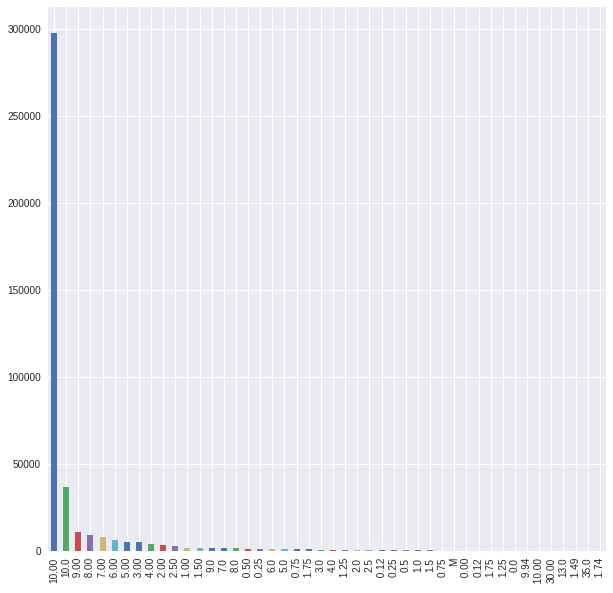

In [34]:
weather["Visibility"].value_counts().plot(kind='bar',figsize=(10,10))

Most values of visibility are 10.0, the 'M' value rarely appears.

We also notice the 'M' value in other columns. Let's zoom in to 3 more columns as an example: **DryBulbFarenheit, Altimeter, SealevelPressure**. Let's calculate the percentage of M's in these columns.

In [35]:
for column in ["Visibility","DryBulbFarenheit", "Altimeter", "SeaLevelPressure"]:
  perc = float(weather[weather[column] == 'M'][column].count())/len(weather)
  print("Fraction of M's in column {0}: {1}".format(column,perc))

Fraction of M's in column Visibility: 0.000265672199864
Fraction of M's in column DryBulbFarenheit: 0.000710919127414
Fraction of M's in column Altimeter: 0.000273051983194
Fraction of M's in column SeaLevelPressure: 0.179328734908


We will remove the column SeaLevelPressure since it contains a lot of useless M's. 

In [0]:
weather.drop(columns=["SeaLevelPressure"],inplace=True)

In the other columns, the M value is rarely seen. We would prefer to keep these columns, since we are not sure a priori that these columns have no influence on the flight delay.

We decide to further clean our data by keeping the columns but simply removing all rows from the dataframe that has an M somewhere.

The function below removes all rows with an M for a general dataframe, from all columns with dtype *object*. Afterwards it attempts to cast the column to float.


In [0]:
def remove_M(df):
    original_length = len(df)
    for c in df.columns.tolist():
        if df.dtypes[c] == 'object':
            m = df[df[c] == "M"][c].count()
            print("Removed {0} in column {1}".format(m,c))
            df = df[df[c] != "M"]
            try: 
                df[c] = df[c].astype(np.float64)
            except:
                pass
    n_removed = original_length - len(df)
    print("")
    print("Removed {0} of {1}".format(n_removed,original_length))
    return df

In [38]:
weather = remove_M(weather)

Removed 108 in column Visibility


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Removed 221 in column DryBulbFarenheit
Removed 0 in column DryBulbCelsius
Removed 1202 in column WetBulbFarenheit
Removed 0 in column WetBulbCelsius
Removed 0 in column DewPointFarenheit
Removed 0 in column DewPointCelsius
Removed 0 in column RelativeHumidity
Removed 41 in column WindSpeed
Removed 29 in column WindDirection
Removed 0 in column StationPressure
Removed 2 in column Altimeter

Removed 1603 of 406516


In [39]:
weather.dtypes

AirportID              int64
Year                   int64
Month                  int64
Day                    int64
Time                   int64
TimeZone               int64
Visibility           float64
DryBulbFarenheit     float64
DryBulbCelsius       float64
WetBulbFarenheit     float64
WetBulbCelsius       float64
DewPointFarenheit    float64
DewPointCelsius      float64
RelativeHumidity     float64
WindSpeed             object
WindDirection         object
StationPressure      float64
Altimeter            float64
dtype: object

Apparently,  columns **WindSpeed** and **WindDirection** still have weird strings as value, since we were not able to cast them to floats. 

In [40]:
print("unique WindSpeed: ",weather["WindSpeed"].unique().shape[0])
weather["WindSpeed"].unique()

('unique WindSpeed: ', 72)


array(['13', '10', ' 9', ' 7', '14', '16', '17', '20', '18', '15', '11',
       ' 5', ' 6', ' 3', ' 8', ' 0', '21', '22', '23', '24', '26', '25',
       '30', '29', '32', '34', '40', '37', '28', '31', '44', '39', '33',
       '38', '36', '43', '41', '45', '53', '  ', '46', '51', '47', '62',
       0, 6, 3, 5, 7, 8, 10, 9, 11, 13, 15, 14, 16, 18, 20, 17, 21, 22,
       23, 24, 26, 25, 31, 30, 33, 28, 29, 36], dtype=object)

Windspeed has empty strings as value, but only very few. We simply remove the rows with an empty WindSpeed from the dataframe, then we can cast the column to numerical.

In [41]:
weather[weather["WindSpeed"] == '  ']["WindSpeed"].count()

3

In [0]:
weather = weather[weather["WindSpeed"] != '  ']
weather["WindSpeed"] = weather["WindSpeed"].astype(np.int64)

**Winddirection** has some value 'VR' that appears an amount of times that is not negligible.

In [43]:
print("unique WindDirection: ",weather["WindDirection"].unique().shape[0])
weather["WindDirection"].unique()

('unique WindDirection: ', 39)


array(['080', '090', '100', '110', '070', '000', '130', '150', '160',
       '120', '170', '180', '060', '230', '200', '050', 'VR ', '140',
       '210', '290', '270', '190', '030', '040', '020', '010', '360',
       '220', '260', '250', '280', '300', '320', '340', '350', '310',
       '240', '330', '239'], dtype=object)

In [44]:
weather[weather["WindDirection"] == 'VR ']["WindSpeed"].count()

11274

The Winddirection ranges from 0 to 360 degrees. We will use one-hot-encoding for the WindDirection, by splitting it up into categories. Every category represents a range of 40 degrees. Another category is reserved for the 'VR' case.

Review the code in the cell below. This cell performs this one-hot-encoding and splits the column into seperate columns for each one-hot-encoded case. 

In [0]:
direction_categories = [0,40,80,120,160,200,240,280,320]
def check_cat(x,cat):
    try: #try-catch block because VR cannot be compared to int.
        if int(x)>cat-20 and int(x)<=cat+20:
            return 1
        else:
            return 0
    except:
        return 0
    
weather["dir_VR"] = weather["WindDirection"].apply(lambda x: 1 if x == 'VR ' else 0)
for cat in direction_categories:
    weather["dir_{0}".format(cat)] = weather["WindDirection"].apply(lambda x: check_cat(x,cat))
weather.drop(columns=["WindDirection"],inplace=True)

The resulting dataframe has columns "dir_0" up to "dir_320"

In [46]:
weather.head()

,AirportID,Year,Month,Day,Time,TimeZone,Visibility,DryBulbFarenheit,DryBulbCelsius,WetBulbFarenheit,...,dir_VR,dir_0,dir_40,dir_80,dir_120,dir_160,dir_200,dir_240,dir_280,dir_320
0,14843,2013,4,1,56,-4,10.0,76.0,24.4,74.0,...,0,0,0,1,0,0,0,0,0,0
1,14843,2013,4,1,156,-4,10.0,76.0,24.4,73.0,...,0,0,0,1,0,0,0,0,0,0
2,14843,2013,4,1,256,-4,10.0,76.0,24.4,73.0,...,0,0,0,1,0,0,0,0,0,0
3,14843,2013,4,1,356,-4,10.0,76.0,24.4,72.0,...,0,0,0,1,0,0,0,0,0,0
4,14843,2013,4,1,456,-4,10.0,76.0,24.4,72.0,...,0,0,0,0,1,0,0,0,0,0


In [47]:
weather.dtypes

AirportID              int64
Year                   int64
Month                  int64
Day                    int64
Time                   int64
TimeZone               int64
Visibility           float64
DryBulbFarenheit     float64
DryBulbCelsius       float64
WetBulbFarenheit     float64
WetBulbCelsius       float64
DewPointFarenheit    float64
DewPointCelsius      float64
RelativeHumidity     float64
WindSpeed              int64
StationPressure      float64
Altimeter            float64
dir_VR                 int64
dir_0                  int64
dir_40                 int64
dir_80                 int64
dir_120                int64
dir_160                int64
dir_200                int64
dir_240                int64
dir_280                int64
dir_320                int64
dtype: object

## 2.4 Handling time

We will use the time information to join the weather dataframe with the delay dataframe. For this, we must format the time information for every row into a fixed format in one column.

We round time to the nearest hour. Time of weather data is rounded UP and time of flight data will be rounded DOWN, to make sure that weather conditions after the flight departure/arrival are not a deciding factor. We create a **datetime** column with strings in the format "YYYY-M-D-H". 

What about the timezone? The weather data is reported in local time. We will leave this in local time and use this to join it to the delay data, where arrival and departure times are also in local times.

In the original dataframe, time of day is written in the HH-mm format:

In [48]:
weather['Time'].head(5)

0     56
1    156
2    256
3    356
4    456
Name: Time, dtype: int64

In [0]:
# function to round the time of day (in HH-mm format) to the nearest hour.
def hhmm_to_h(hhmm, mode):
    #mode = 'up' or 'down'
    if not (mode == 'up' or mode == 'down'):
        raise Exception("mode must be up or down")
    if len(str(hhmm)) <= 2:
        if mode == 'up':
            h = 1
        else:
            h = 0
    else:
        h = int(str(hhmm)[:-2])
        if mode == 'up':
            h += 1
    return h

In [0]:
#first create a column "hour" to round the time to the nearest hour.

weather["hour"] = weather["Time"].apply(lambda x: hhmm_to_h(x,mode='up'))

In [51]:
weather['hour'].head(5)

0    1
1    2
2    3
3    4
4    5
Name: hour, dtype: int64

In [0]:
#then, create a datetime string from the columns Year, Month, Day and hour. Note how operations on series can be easily done thanks to broadcasting.

weather["datetime"] = weather["Year"].astype(str)+'-'+weather["Month"].astype(str)+'-'+weather["Day"].astype(str)+'-'+weather["hour"].astype(str)

In [53]:
weather['datetime'].head(5)

0    2013-4-1-1
1    2013-4-1-2
2    2013-4-1-3
3    2013-4-1-4
4    2013-4-1-5
Name: datetime, dtype: object

In [54]:
weather.dtypes

AirportID              int64
Year                   int64
Month                  int64
Day                    int64
Time                   int64
TimeZone               int64
Visibility           float64
DryBulbFarenheit     float64
DryBulbCelsius       float64
WetBulbFarenheit     float64
WetBulbCelsius       float64
DewPointFarenheit    float64
DewPointCelsius      float64
RelativeHumidity     float64
WindSpeed              int64
StationPressure      float64
Altimeter            float64
dir_VR                 int64
dir_0                  int64
dir_40                 int64
dir_80                 int64
dir_120                int64
dir_160                int64
dir_200                int64
dir_240                int64
dir_280                int64
dir_320                int64
hour                   int64
datetime              object
dtype: object

## 2.5 Result

Dropping some columns that we no longer need.

In [0]:
weather.drop(columns=["Year","Month","Day","Time","TimeZone","hour"],inplace=True)

The temperature information is redundant: it has both the farenheit and celcius values. We will drop the Farenheit columns. We also drop the Altimeter column.

In [0]:
weather.drop(columns=["DryBulbFarenheit","WetBulbFarenheit","DewPointFarenheit","Altimeter"],inplace=True)

In [57]:
weather.head()

,AirportID,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure,dir_VR,dir_0,dir_40,dir_80,dir_120,dir_160,dir_200,dir_240,dir_280,dir_320,datetime
0,14843,10.0,24.4,23.3,22.8,90.0,13,30.06,0,0,0,1,0,0,0,0,0,0,2013-4-1-1
1,14843,10.0,24.4,22.5,21.7,85.0,10,30.05,0,0,0,1,0,0,0,0,0,0,2013-4-1-2
2,14843,10.0,24.4,22.5,21.7,85.0,9,30.03,0,0,0,1,0,0,0,0,0,0,2013-4-1-3
3,14843,10.0,24.4,22.2,21.1,82.0,9,30.02,0,0,0,1,0,0,0,0,0,0,2013-4-1-4
4,14843,10.0,24.4,22.2,21.1,82.0,7,30.03,0,0,0,0,1,0,0,0,0,0,2013-4-1-5


## 2.6 memory usage and dtypes

When working with small amounts of data, Pandas works without any problems. For larger datasets, memory usage of the Pandas dataframes becomes to high and the runtime could possible crash. Therefore, we will try to optimize memory usage. If we don't, this notebook will crash when running in the Colaboratory environment. 

In order to minimize the memory footprint, we have to look at the dtypes of the columns.

In [58]:
weather.dtypes

AirportID             int64
Visibility          float64
DryBulbCelsius      float64
WetBulbCelsius      float64
DewPointCelsius     float64
RelativeHumidity    float64
WindSpeed             int64
StationPressure     float64
dir_VR                int64
dir_0                 int64
dir_40                int64
dir_80                int64
dir_120               int64
dir_160               int64
dir_200               int64
dir_240               int64
dir_280               int64
dir_320               int64
datetime             object
dtype: object

Pandas uses Numpy arrays internally. Columns of the same dtype are internally stored together in one Numpy Array. 

The choice of dtype determines the memory usage of the column. A more detailed discussion about memory usage in Pandas is found in this [blog](https://www.dataquest.io/blog/pandas-big-data/), but the ongoing disucssion will make sense without reading the blog.

We can inspect a dataframes memory usage as follows:

In [59]:
weather.info(memory_usage='deep',max_cols=1) #without memory_usage = 'deep', the displayed memory usage is a less accurate approximation.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404910 entries, 0 to 406515
Columns: 19 entries, AirportID to datetime
dtypes: float64(6), int64(12), object(1)
memory usage: 80.5 MB


**currently, our memory usage of the weather dataframe is about 80MB**

In [60]:
weather.head()

,AirportID,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure,dir_VR,dir_0,dir_40,dir_80,dir_120,dir_160,dir_200,dir_240,dir_280,dir_320,datetime
0,14843,10.0,24.4,23.3,22.8,90.0,13,30.06,0,0,0,1,0,0,0,0,0,0,2013-4-1-1
1,14843,10.0,24.4,22.5,21.7,85.0,10,30.05,0,0,0,1,0,0,0,0,0,0,2013-4-1-2
2,14843,10.0,24.4,22.5,21.7,85.0,9,30.03,0,0,0,1,0,0,0,0,0,0,2013-4-1-3
3,14843,10.0,24.4,22.2,21.1,82.0,9,30.02,0,0,0,1,0,0,0,0,0,0,2013-4-1-4
4,14843,10.0,24.4,22.2,21.1,82.0,7,30.03,0,0,0,0,1,0,0,0,0,0,2013-4-1-5


Observe the possible values for the following columns...

In [61]:
weather["WindSpeed"].unique()

array([13, 10,  9,  7, 14, 16, 17, 20, 18, 15, 11,  5,  6,  3,  8,  0, 21,
       22, 23, 24, 26, 25, 30, 29, 32, 34, 40, 37, 28, 31, 44, 39, 33, 38,
       36, 43, 41, 45, 53, 46, 51, 47, 62])

In [62]:
weather["RelativeHumidity"].unique()

array([ 90.,  85.,  82.,  79.,  74.,  72.,  65.,  63.,  59.,  61.,  57.,
        67.,  69.,  71.,  77.,  55.,  50.,  48.,  47.,  42.,  44.,  53.,
        76.,  87.,  52.,  88.,  70.,  68.,  45.,  84.,  93.,  94.,  51.,
        56.,  58.,  60.,  64.,  66.,  97.,  75.,  78.,  81.,  62.,  43.,
        41.,  49.,  37.,  39.,  38.,  46.,  54., 100.,  96.,  86.,  73.,
        40.,  91.,  83.,  80.,  36.,  33.,  34.,  35.,  89.,  31.,  30.,
        29.,  27.,  22.,  20.,  23.,  25.,  32.,  26.,  19.,  21.,  18.,
        17.,  16.,  28.,  24.,  15.,  14.,  92.,  13.,  11.,   9.,   8.,
         7.,  10.,  12.,   6.,   4.,   5.,   3.,   2.,   1.])

In [63]:
weather["Visibility"].unique()

array([10.  ,  8.  ,  9.  ,  1.  ,  2.  ,  4.  ,  6.  ,  7.  ,  3.  ,
        5.  ,  0.5 ,  0.75,  1.5 ,  1.49,  2.5 ,  1.75,  1.25,  0.25,
        0.12,  0.  ,  9.94, 35.  ])

In [0]:
#weather["Altimeter"].unique()

In [65]:
weather[["StationPressure","Visibility","DryBulbCelsius","WetBulbCelsius","DewPointCelsius","RelativeHumidity"]].head()

,StationPressure,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity
0,30.06,10.0,24.4,23.3,22.8,90.0
1,30.05,10.0,24.4,22.5,21.7,85.0
2,30.03,10.0,24.4,22.5,21.7,85.0
3,30.02,10.0,24.4,22.2,21.1,82.0
4,30.03,10.0,24.4,22.2,21.1,82.0


In [66]:
print("minimum and maximum column values")
for columname in ["Visibility","StationPressure"]:
  print("{0}: minimum = {1}, maximum = {2}".format(columname,weather[columname].min(),weather[columname].max()))

minimum and maximum column values
Visibility: minimum = 0.0, maximum = 35.0
StationPressure: minimum = 24.17, maximum = 30.74


The interger type has subtypes int8, int 16, int32 and int64. These subtypes have a different memory footprint. An int8 is stored in one byte (8 bits), so it can take 2^8=256 values in total. Thus, it can represent numbers between -128 and 127 (including 0). An int64 is stored in 8 bytes and can take much larger values.

**(1) integers**

Currently, all our integer columns are int64. We can reduce our memory usage a lot. One of our integer columns, windspeed, ranges from 0 to 64. There is clearly no need for an int64, an int8 would be sufficient. Even the one-hot encoded columns are int64, while they only take the values 0 and 1. 

A handy way to check the minimal and maximum values of a dtype is np.iinfo() or np.finfo().






In [67]:
print(np.iinfo(np.int64))
print(np.iinfo(np.int8))

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------



We will **downcast** the one-hot columns and the windspeed to **int8** in the cell below with [pd.to_numeric()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_numeric.html). As an exercise, one might investigate wether an int64 is required for AirportID and optionally downcast it.

The to_numeric() method with the 'downcast' parameter will automatically pick the best possible dtype.

In [0]:
for columnname in ["WindSpeed","dir_0","dir_40","dir_80","dir_120","dir_160","dir_200","dir_240","dir_280","dir_320"]:
  weather[columnname] = pd.to_numeric(weather[columnname],downcast="integer")

**(2) floats**

The "float" type has subtypes float16, float32, float64 and float128. Currently, all floats are of dtype float64.

It is clear that the RelativeHumidity column has simple integer values disguised as floats. The decimal is always zero. We will downcast this to int8. 




In [0]:
# weather["RelativeHumididty"] = pd.to_numeric(weather["RelativeHumidity"], downcast="float")

The RelativeHumidity, Visiblity, StationPressure and Altimeter columns are floats with decimals, but there minimum and maximum values don't require a float64 - by far. Let's see the minimum and maximum values for some float types.

In [70]:
print(np.finfo(np.float64))
print(np.finfo(np.float32))
print(np.finfo(np.float16))


Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------

Machine parameters for float16
---------------------------------------------------------------
precision =   3 

Looks like a smaller float will do. Downcast!

In [0]:
for columnname in ["StationPressure","Visibility","DryBulbCelsius","WetBulbCelsius","DewPointCelsius","RelativeHumidity"]:
  weather[columnname] = pd.to_numeric(weather[columnname],downcast="float")

In [72]:
weather.info(memory_usage="deep",max_cols=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404910 entries, 0 to 406515
Columns: 19 entries, AirportID to datetime
dtypes: float32(6), int64(2), int8(10), object(1)
memory usage: 44.2 MB


In [73]:
weather.head()

,AirportID,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure,dir_VR,dir_0,dir_40,dir_80,dir_120,dir_160,dir_200,dir_240,dir_280,dir_320,datetime
0,14843,10.0,24.4,23.299999,22.799999,90.0,13,30.059999,0,0,0,1,0,0,0,0,0,0,2013-4-1-1
1,14843,10.0,24.4,22.500000,21.700001,85.0,10,30.049999,0,0,0,1,0,0,0,0,0,0,2013-4-1-2
2,14843,10.0,24.4,22.500000,21.700001,85.0,9,30.030001,0,0,0,1,0,0,0,0,0,0,2013-4-1-3
3,14843,10.0,24.4,22.200001,21.100000,82.0,9,30.020000,0,0,0,1,0,0,0,0,0,0,2013-4-1-4
4,14843,10.0,24.4,22.200001,21.100000,82.0,7,30.030001,0,0,0,0,1,0,0,0,0,0,2013-4-1-5


# 3 Cleaning delay data



## 3.1 Dropping and one-hot-encoding

In [74]:
delays.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0.0,0.0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0.0,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0.0,0.0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1.0,0.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0.0,0.0


In [75]:
delays.dtypes

Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
Carrier             object
OriginAirportID      int64
DestAirportID        int64
CRSDepTime           int64
DepDelay           float64
DepDel15           float64
CRSArrTime           int64
ArrDelay           float64
ArrDel15           float64
Cancelled          float64
dtype: object

**DayOfWeek** has values ranging from 0 (Monday) to 6 (Sunday). We will not need this column so we drop it.

In [76]:
print("unique DayOfWeek: ",delays["DayOfWeek"].unique().shape[0])
delays["DayOfWeek"].unique()

('unique DayOfWeek: ', 7)


array([5, 6, 4, 2, 3, 7, 1])

In [0]:
delays.drop(columns = "DayOfWeek",inplace=True)

**Carrier** is a categorical value with 16 categories. 

In [78]:
print("unique Carrier: ",delays["Carrier"].unique().shape[0])
delays["Carrier"].unique()

('unique Carrier: ', 16)


array(['DL', 'AA', 'EV', 'B6', 'F9', 'FL', 'HA', 'MQ', '9E', 'AS', 'US',
       'UA', 'VX', 'WN', 'YV', 'OO'], dtype=object)

We will one-hot encode this column. Below is a function to perform this one-hot-encoding. Notice the important memory optimization! Later we will use this function to one-hot encode the airportID's which creates over hundred new columns. You are not able to run this one-hot-encoding without the memory optimization line.

In [0]:
def one_hot(df,features):
    all_column_names = []
    for feature in features:
        names = list(df[feature].unique())
        for i, name in enumerate(names):
            column_name = str(feature)+'_'+str(i)
            df[column_name] = df[feature].apply(lambda x: 1 if x==name else 0)
            df[column_name] = pd.to_numeric(df[column_name],downcast='integer') #memory optimization!!
            all_column_names.append(column_name)
    df.drop(columns=features)
    return df

In [0]:
delays = one_hot(delays,["Carrier"])

## 3.2 Handling time

Departure and arrival times: we round **CRSDepTime** and **CRSArrTime** to the nearest hour, creating the columns **Dep_hour** and **Arr_hour**. We round *down*, while the hour of the weather was rounded *up*.  This is to make sure that weather conditions after the flight departure/arrival are not a deciding factor.

In [0]:
delays["Dep_hour"] = delays["CRSDepTime"].apply(lambda x: hhmm_to_h(x,mode="down"))
delays["Arr_hour"] = delays["CRSArrTime"].apply(lambda x: hhmm_to_h(x,mode="down"))

In [82]:
delays.head()

,Year,Month,DayofMonth,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,...,Carrier_8,Carrier_9,Carrier_10,Carrier_11,Carrier_12,Carrier_13,Carrier_14,Carrier_15,Dep_hour,Arr_hour
0,2013,4,19,DL,11433,13303,837,-3.0,0.0,1138,...,0,0,0,0,0,0,0,0,8,11
1,2013,4,19,DL,14869,12478,1705,0.0,0.0,2336,...,0,0,0,0,0,0,0,0,17,23
2,2013,4,19,DL,14057,14869,600,-4.0,0.0,851,...,0,0,0,0,0,0,0,0,6,8
3,2013,4,19,DL,15016,11433,1630,28.0,1.0,1903,...,0,0,0,0,0,0,0,0,16,19
4,2013,4,19,DL,11193,12892,1615,-6.0,0.0,1805,...,0,0,0,0,0,0,0,0,16,18


In [83]:
delays.columns

Index([u'Year', u'Month', u'DayofMonth', u'Carrier', u'OriginAirportID',
       u'DestAirportID', u'CRSDepTime', u'DepDelay', u'DepDel15',
       u'CRSArrTime', u'ArrDelay', u'ArrDel15', u'Cancelled', u'Carrier_0',
       u'Carrier_1', u'Carrier_2', u'Carrier_3', u'Carrier_4', u'Carrier_5',
       u'Carrier_6', u'Carrier_7', u'Carrier_8', u'Carrier_9', u'Carrier_10',
       u'Carrier_11', u'Carrier_12', u'Carrier_13', u'Carrier_14',
       u'Carrier_15', u'Dep_hour', u'Arr_hour'],
      dtype='object')

In [84]:
delays.dtypes

Year                 int64
Month                int64
DayofMonth           int64
Carrier             object
OriginAirportID      int64
DestAirportID        int64
CRSDepTime           int64
DepDelay           float64
DepDel15           float64
CRSArrTime           int64
ArrDelay           float64
ArrDel15           float64
Cancelled          float64
Carrier_0             int8
Carrier_1             int8
Carrier_2             int8
Carrier_3             int8
Carrier_4             int8
Carrier_5             int8
Carrier_6             int8
Carrier_7             int8
Carrier_8             int8
Carrier_9             int8
Carrier_10            int8
Carrier_11            int8
Carrier_12            int8
Carrier_13            int8
Carrier_14            int8
Carrier_15            int8
Dep_hour             int64
Arr_hour             int64
dtype: object

We will create columns **Dep_datetime** and **Arr_datetime** in the same format as the **Datetime** column in the weather dataset. We will use these columns later to join the delay data with the weather data.

By inspecting the columns above, we can see that the flight info has only one 'DayofMonth'. We assume this is the day of *departure*. However, when a flight takes place overnight, the arrival might be on the next day. This must be taken into account when constructing the Dep_datetime and Arr_datetime columns.

We assume the departure and arrival hour (Dep_hour and Arr_hour) are in the local timezone of the departure and arrival airports respectively. If departure time is later than arrival time, then the arrival is on the next day, so this must be taken into account when constructing Arr_datetime and Dep_datetime (add one day to Dep_datetime). 

We introduce the helper column **dep_after_arr** (1 or 0). This column is '1' if the arrival date in on the next day and '0' otherwise.



In [0]:
delays["dep_after_arr"] = (delays["CRSArrTime"]<delays["CRSDepTime"])

In [0]:
delays["Dep_datetime"] = delays["Year"].astype(str)+'-'+delays["Month"].astype(str)+'-'+delays["DayofMonth"].astype(str)+'-'+delays["Dep_hour"].astype(str)

We add an extra helper column **DayofMonth_arr**, the day of month of *arrival*. This is one day later than the **DayofMonth** column if arrival is one day later (i.e, when dep_after_arr is 1) and the same as **DayofMonth** otherwise.

In [0]:
delays["DayofMonth_arr"] = delays["DayofMonth"]+delays["dep_after_arr"]

From this, we can create **Arr_datetime**

In [0]:
delays["Arr_datetime"] = delays["Year"].astype(str)+'-'+delays["Month"].astype(str)+'-'+delays["DayofMonth_arr"].astype(str)+'-'+delays["Arr_hour"].astype(str)

## 3.3 Result

Let's drop some columns we no longer need.

In [0]:
delays.drop(columns=["dep_after_arr","DayofMonth","DayofMonth_arr","CRSArrTime", "CRSDepTime","Dep_hour","Arr_hour","Year","Month","Carrier"],inplace=True)

The result is as follows..

In [90]:
delays.head()

,OriginAirportID,DestAirportID,DepDelay,DepDel15,ArrDelay,ArrDel15,Cancelled,Carrier_0,Carrier_1,Carrier_2,...,Carrier_8,Carrier_9,Carrier_10,Carrier_11,Carrier_12,Carrier_13,Carrier_14,Carrier_15,Dep_datetime,Arr_datetime
0,11433,13303,-3.0,0.0,1.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-8,2013-4-19-11
1,14869,12478,0.0,0.0,-8.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-17,2013-4-19-23
2,14057,14869,-4.0,0.0,-15.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-6,2013-4-19-8
3,15016,11433,28.0,1.0,24.0,1.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-16,2013-4-19-19
4,11193,12892,-6.0,0.0,-11.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-16,2013-4-19-18


## 3.4 memory usage and dtypes



In [91]:
delays.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2719418 entries, 0 to 2719417
Data columns (total 25 columns):
OriginAirportID    int64
DestAirportID      int64
DepDelay           float64
DepDel15           float64
ArrDelay           float64
ArrDel15           float64
Cancelled          float64
Carrier_0          int8
Carrier_1          int8
Carrier_2          int8
Carrier_3          int8
Carrier_4          int8
Carrier_5          int8
Carrier_6          int8
Carrier_7          int8
Carrier_8          int8
Carrier_9          int8
Carrier_10         int8
Carrier_11         int8
Carrier_12         int8
Carrier_13         int8
Carrier_14         int8
Carrier_15         int8
Dep_datetime       object
Arr_datetime       object
dtypes: float64(5), int64(2), int8(16), object(2)
memory usage: 480.4 MB


In [92]:
delays.dtypes

OriginAirportID      int64
DestAirportID        int64
DepDelay           float64
DepDel15           float64
ArrDelay           float64
ArrDel15           float64
Cancelled          float64
Carrier_0             int8
Carrier_1             int8
Carrier_2             int8
Carrier_3             int8
Carrier_4             int8
Carrier_5             int8
Carrier_6             int8
Carrier_7             int8
Carrier_8             int8
Carrier_9             int8
Carrier_10            int8
Carrier_11            int8
Carrier_12            int8
Carrier_13            int8
Carrier_14            int8
Carrier_15            int8
Dep_datetime        object
Arr_datetime        object
dtype: object

In [93]:
delays.head()

,OriginAirportID,DestAirportID,DepDelay,DepDel15,ArrDelay,ArrDel15,Cancelled,Carrier_0,Carrier_1,Carrier_2,...,Carrier_8,Carrier_9,Carrier_10,Carrier_11,Carrier_12,Carrier_13,Carrier_14,Carrier_15,Dep_datetime,Arr_datetime
0,11433,13303,-3.0,0.0,1.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-8,2013-4-19-11
1,14869,12478,0.0,0.0,-8.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-17,2013-4-19-23
2,14057,14869,-4.0,0.0,-15.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-6,2013-4-19-8
3,15016,11433,28.0,1.0,24.0,1.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-16,2013-4-19-19
4,11193,12892,-6.0,0.0,-11.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-16,2013-4-19-18


DepDelay and ArrDelay are now floats but they can be casted to integers. ArrDelay15 and Cancelled are floats that are actually binary 1 or 0. The one-hot encoded features are int64, while an int8 should be sufficient. 

We will downcast all values as integers, except for the datetime columns.

In [94]:
delays.columns[0:-2]

Index([u'OriginAirportID', u'DestAirportID', u'DepDelay', u'DepDel15',
       u'ArrDelay', u'ArrDel15', u'Cancelled', u'Carrier_0', u'Carrier_1',
       u'Carrier_2', u'Carrier_3', u'Carrier_4', u'Carrier_5', u'Carrier_6',
       u'Carrier_7', u'Carrier_8', u'Carrier_9', u'Carrier_10', u'Carrier_11',
       u'Carrier_12', u'Carrier_13', u'Carrier_14', u'Carrier_15'],
      dtype='object')

In [0]:
for columnname in delays.columns[0:-2]: #excluse the last two (datetimes Dep_datetime and Arr_datetime objects)
  delays[columnname] = pd.to_numeric(delays[columnname],downcast="integer")

In [96]:
delays.dtypes

OriginAirportID      int16
DestAirportID        int16
DepDelay           float64
DepDel15           float64
ArrDelay           float64
ArrDel15              int8
Cancelled             int8
Carrier_0             int8
Carrier_1             int8
Carrier_2             int8
Carrier_3             int8
Carrier_4             int8
Carrier_5             int8
Carrier_6             int8
Carrier_7             int8
Carrier_8             int8
Carrier_9             int8
Carrier_10            int8
Carrier_11            int8
Carrier_12            int8
Carrier_13            int8
Carrier_14            int8
Carrier_15            int8
Dep_datetime        object
Arr_datetime        object
dtype: object

In [97]:
delays.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2719418 entries, 0 to 2719417
Data columns (total 25 columns):
OriginAirportID    int16
DestAirportID      int16
DepDelay           float64
DepDel15           float64
ArrDelay           float64
ArrDel15           int8
Cancelled          int8
Carrier_0          int8
Carrier_1          int8
Carrier_2          int8
Carrier_3          int8
Carrier_4          int8
Carrier_5          int8
Carrier_6          int8
Carrier_7          int8
Carrier_8          int8
Carrier_9          int8
Carrier_10         int8
Carrier_11         int8
Carrier_12         int8
Carrier_13         int8
Carrier_14         int8
Carrier_15         int8
Dep_datetime       object
Arr_datetime       object
dtypes: float64(3), int16(2), int8(18), object(2)
memory usage: 413.0 MB


# 4 Join with OriginAirport weather

Apparently, in the weather data sometimes for the same airport two measurements are available in the same hour (i.e. same datetime). We need to drop these duplicates (keeping the last available) so that we have unique airport-datetime combinations. Then, we can index on these columns (double index) and join the dataframes. 

In [0]:
weather.drop_duplicates(subset=["AirportID","datetime"],keep="last",inplace=True)

In [0]:
weather.set_index(keys=["AirportID","datetime"],inplace=True)

In [100]:
weather.head(5)

Visibility  DryBulbCelsius  WetBulbCelsius  \
AirportID datetime                                                 
14843     2013-4-1-1        10.0            24.4       23.299999   
          2013-4-1-2        10.0            24.4       22.500000   
          2013-4-1-3        10.0            24.4       22.500000   
          2013-4-1-4        10.0            24.4       22.200001   
          2013-4-1-5        10.0            24.4       22.200001   

                      DewPointCelsius  RelativeHumidity  WindSpeed  \
AirportID datetime                                                   
14843     2013-4-1-1        22.799999              90.0         13   
          2013-4-1-2        21.700001              85.0         10   
          2013-4-1-3        21.700001              85.0          9   
          2013-4-1-4        21.100000              82.0          9   
          2013-4-1-5        21.100000              82.0          7   

                      StationPressure  dir_VR  dir_0  dir_40  dir_80  dir_120  \
AirportID datetime                                                              
14843     2013-4-1-1        30.059999       0      0       0       1        0   
          2013-4-1-2        30.049999       0      0       0       1        0   
          2013-4-1-3        30.030001       0      0       0       1        0   
          2013-4-1-4        30.020000       0      0       0       1        0   
          2013-4-1-5        30.030001       0      0       0       0        1   

                      dir_160  dir_200  dir_240  dir_280  dir_320  
AirportID datetime                                                 
14843     2013-4-1-1        0        0        0        0        0  
          2013-4-1-2        0        0        0        0        0  
          2013-4-1-3        0        0        0        0        0  
          2013-4-1-4        0        0        0        0        0  
          2013-4-1-5        0        0        0        0        0

In [101]:
delays.dtypes

OriginAirportID      int16
DestAirportID        int16
DepDelay           float64
DepDel15           float64
ArrDelay           float64
ArrDel15              int8
Cancelled             int8
Carrier_0             int8
Carrier_1             int8
Carrier_2             int8
Carrier_3             int8
Carrier_4             int8
Carrier_5             int8
Carrier_6             int8
Carrier_7             int8
Carrier_8             int8
Carrier_9             int8
Carrier_10            int8
Carrier_11            int8
Carrier_12            int8
Carrier_13            int8
Carrier_14            int8
Carrier_15            int8
Dep_datetime        object
Arr_datetime        object
dtype: object

We are now ready to add the weather information to our delays dataframe. We will first join with the weather at the departure airport. 

In order to perform the join, we must temporarily rename our OriginAirportID to AirportID and Dep_datetime to datetime. The column names to be joined on, are then equal in both dataframes of the join.

In [0]:
delays.rename(columns={"OriginAirportID":"AirportID","Dep_datetime":"datetime"},inplace=True)

Now, adding the weather of the departure airport to the dataframe...

In [103]:
delays.head()

,AirportID,DestAirportID,DepDelay,DepDel15,ArrDelay,ArrDel15,Cancelled,Carrier_0,Carrier_1,Carrier_2,...,Carrier_8,Carrier_9,Carrier_10,Carrier_11,Carrier_12,Carrier_13,Carrier_14,Carrier_15,datetime,Arr_datetime
0,11433,13303,-3.0,0.0,1.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-8,2013-4-19-11
1,14869,12478,0.0,0.0,-8.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-17,2013-4-19-23
2,14057,14869,-4.0,0.0,-15.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-6,2013-4-19-8
3,15016,11433,28.0,1.0,24.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-16,2013-4-19-19
4,11193,12892,-6.0,0.0,-11.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2013-4-19-16,2013-4-19-18


In [0]:
delays=delays.join(weather,on=["AirportID","datetime"])#,rsuffix="_depweather")

In [105]:
delays.columns

Index([u'AirportID', u'DestAirportID', u'DepDelay', u'DepDel15', u'ArrDelay',
       u'ArrDel15', u'Cancelled', u'Carrier_0', u'Carrier_1', u'Carrier_2',
       u'Carrier_3', u'Carrier_4', u'Carrier_5', u'Carrier_6', u'Carrier_7',
       u'Carrier_8', u'Carrier_9', u'Carrier_10', u'Carrier_11', u'Carrier_12',
       u'Carrier_13', u'Carrier_14', u'Carrier_15', u'datetime',
       u'Arr_datetime', u'Visibility', u'DryBulbCelsius', u'WetBulbCelsius',
       u'DewPointCelsius', u'RelativeHumidity', u'WindSpeed',
       u'StationPressure', u'dir_VR', u'dir_0', u'dir_40', u'dir_80',
       u'dir_120', u'dir_160', u'dir_200', u'dir_240', u'dir_280', u'dir_320'],
      dtype='object')

A lot of columns have been added related to the weather at the origin airport. We will rename all these columns with a suffix **_originairport** so that we can distinct them later from the weather data of the destination airport. We also change  AirportID back to OriginAirportID and datetime to Dep_datetime

In [106]:
delays_columns_old = delays.columns
delays_columns_new = []
for column in delays_columns_old:
    if column in weather.columns:
        delays_columns_new.append(column+"_originAirport")
    else:
        delays_columns_new.append(column)
        
delays.columns = delays_columns_new
delays.rename(columns={"AirportID":"OriginAirportID","datetime":"Dep_datetime"},inplace=True)
delays.columns

Index([u'OriginAirportID', u'DestAirportID', u'DepDelay', u'DepDel15',
       u'ArrDelay', u'ArrDel15', u'Cancelled', u'Carrier_0', u'Carrier_1',
       u'Carrier_2', u'Carrier_3', u'Carrier_4', u'Carrier_5', u'Carrier_6',
       u'Carrier_7', u'Carrier_8', u'Carrier_9', u'Carrier_10', u'Carrier_11',
       u'Carrier_12', u'Carrier_13', u'Carrier_14', u'Carrier_15',
       u'Dep_datetime', u'Arr_datetime', u'Visibility_originAirport',
       u'DryBulbCelsius_originAirport', u'WetBulbCelsius_originAirport',
       u'DewPointCelsius_originAirport', u'RelativeHumidity_originAirport',
       u'WindSpeed_originAirport', u'StationPressure_originAirport',
       u'dir_VR_originAirport', u'dir_0_originAirport',
       u'dir_40_originAirport', u'dir_80_originAirport',
       u'dir_120_originAirport', u'dir_160_originAirport',
       u'dir_200_originAirport', u'dir_240_originAirport',
       u'dir_280_originAirport', u'dir_320_originAirport'],
      dtype='object')

# 5 Join with DestinationAirport weather

We now perform the same tricks with the destination airport weather.

In [0]:
delays.rename(columns={"DestAirportID":"AirportID","Arr_datetime":"datetime"},inplace=True)

In [0]:
delays=delays.join(weather,on=["AirportID","datetime"])#,rsuffix="_arrweather")

In [109]:
delays.columns

Index([u'OriginAirportID', u'AirportID', u'DepDelay', u'DepDel15', u'ArrDelay',
       u'ArrDel15', u'Cancelled', u'Carrier_0', u'Carrier_1', u'Carrier_2',
       u'Carrier_3', u'Carrier_4', u'Carrier_5', u'Carrier_6', u'Carrier_7',
       u'Carrier_8', u'Carrier_9', u'Carrier_10', u'Carrier_11', u'Carrier_12',
       u'Carrier_13', u'Carrier_14', u'Carrier_15', u'Dep_datetime',
       u'datetime', u'Visibility_originAirport',
       u'DryBulbCelsius_originAirport', u'WetBulbCelsius_originAirport',
       u'DewPointCelsius_originAirport', u'RelativeHumidity_originAirport',
       u'WindSpeed_originAirport', u'StationPressure_originAirport',
       u'dir_VR_originAirport', u'dir_0_originAirport',
       u'dir_40_originAirport', u'dir_80_originAirport',
       u'dir_120_originAirport', u'dir_160_originAirport',
       u'dir_200_originAirport', u'dir_240_originAirport',
       u'dir_280_originAirport', u'dir_320_originAirport', u'Visibility',
       u'DryBulbCelsius', u'WetBulbCelsius', u

In [110]:
delays_columns_old = delays.columns
delays_columns_new = []
for column in delays_columns_old:
    if column in weather.columns:
        delays_columns_new.append(column+"_destAirport")
    else:
        delays_columns_new.append(column)
        
delays.columns = delays_columns_new
delays.rename(columns={"AirportID":"DestAirportID","datetime":"Arr_datetime"},inplace=True)
delays.columns

Index([u'OriginAirportID', u'DestAirportID', u'DepDelay', u'DepDel15',
       u'ArrDelay', u'ArrDel15', u'Cancelled', u'Carrier_0', u'Carrier_1',
       u'Carrier_2', u'Carrier_3', u'Carrier_4', u'Carrier_5', u'Carrier_6',
       u'Carrier_7', u'Carrier_8', u'Carrier_9', u'Carrier_10', u'Carrier_11',
       u'Carrier_12', u'Carrier_13', u'Carrier_14', u'Carrier_15',
       u'Dep_datetime', u'Arr_datetime', u'Visibility_originAirport',
       u'DryBulbCelsius_originAirport', u'WetBulbCelsius_originAirport',
       u'DewPointCelsius_originAirport', u'RelativeHumidity_originAirport',
       u'WindSpeed_originAirport', u'StationPressure_originAirport',
       u'dir_VR_originAirport', u'dir_0_originAirport',
       u'dir_40_originAirport', u'dir_80_originAirport',
       u'dir_120_originAirport', u'dir_160_originAirport',
       u'dir_200_originAirport', u'dir_240_originAirport',
       u'dir_280_originAirport', u'dir_320_originAirport',
       u'Visibility_destAirport', u'DryBulbCelsius_de

In [111]:
delays.head()

,OriginAirportID,DestAirportID,DepDelay,DepDel15,ArrDelay,ArrDel15,Cancelled,Carrier_0,Carrier_1,Carrier_2,...,dir_VR_destAirport,dir_0_destAirport,dir_40_destAirport,dir_80_destAirport,dir_120_destAirport,dir_160_destAirport,dir_200_destAirport,dir_240_destAirport,dir_280_destAirport,dir_320_destAirport
0,11433,13303,-3.0,0.0,1.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,14869,12478,0.0,0.0,-8.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,14057,14869,-4.0,0.0,-15.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,15016,11433,28.0,1.0,24.0,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,11193,12892,-6.0,0.0,-11.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [112]:
delays.dtypes

OriginAirportID                     int16
DestAirportID                       int16
DepDelay                          float64
DepDel15                          float64
ArrDelay                          float64
ArrDel15                             int8
Cancelled                            int8
Carrier_0                            int8
Carrier_1                            int8
Carrier_2                            int8
Carrier_3                            int8
Carrier_4                            int8
Carrier_5                            int8
Carrier_6                            int8
Carrier_7                            int8
Carrier_8                            int8
Carrier_9                            int8
Carrier_10                           int8
Carrier_11                           int8
Carrier_12                           int8
Carrier_13                           int8
Carrier_14                           int8
Carrier_15                           int8
Dep_datetime                      

# 6 Final data processing and result

Finally, we drop some unneeded columns. Let's assume that the exact flight times don't matter, only the weather conditions at those times. For now the only target variable is ArrDelay15, we exclude other related columns.

In [0]:
delays.drop(columns=["Dep_datetime","Arr_datetime","DepDelay","DepDel15","ArrDelay","Cancelled"],inplace=True)


Dropping NaN values

In [0]:
delays.dropna(inplace=True)

In [115]:
delays.dtypes

OriginAirportID                     int16
DestAirportID                       int16
ArrDel15                             int8
Carrier_0                            int8
Carrier_1                            int8
Carrier_2                            int8
Carrier_3                            int8
Carrier_4                            int8
Carrier_5                            int8
Carrier_6                            int8
Carrier_7                            int8
Carrier_8                            int8
Carrier_9                            int8
Carrier_10                           int8
Carrier_11                           int8
Carrier_12                           int8
Carrier_13                           int8
Carrier_14                           int8
Carrier_15                           int8
Visibility_originAirport          float32
DryBulbCelsius_originAirport      float32
WetBulbCelsius_originAirport      float32
DewPointCelsius_originAirport     float32
RelativeHumidity_originAirport    

During the join, our columns related to Windspeed and Wind Direction are now back to float64. Cast them back to integers to conserve memory

In [116]:
delays.info(memory_usage='deep',max_cols=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138043 entries, 0 to 2719417
Columns: 53 entries, OriginAirportID to dir_320_destAirport
dtypes: float32(12), float64(22), int16(2), int8(17)
memory usage: 515.9 MB


In [0]:
def isDowncastColumn(columnName):
    if ("dir_" in columnName) or ("WindSpeed" in columnName):
      return True
    else:
      return False
    
for columnName in filter(isDowncastColumn,list(delays.columns)):
  delays[columnName] = pd.to_numeric(delays[columnName],downcast='integer')

In [118]:
delays.dtypes

OriginAirportID                     int16
DestAirportID                       int16
ArrDel15                             int8
Carrier_0                            int8
Carrier_1                            int8
Carrier_2                            int8
Carrier_3                            int8
Carrier_4                            int8
Carrier_5                            int8
Carrier_6                            int8
Carrier_7                            int8
Carrier_8                            int8
Carrier_9                            int8
Carrier_10                           int8
Carrier_11                           int8
Carrier_12                           int8
Carrier_13                           int8
Carrier_14                           int8
Carrier_15                           int8
Visibility_originAirport          float32
DryBulbCelsius_originAirport      float32
WetBulbCelsius_originAirport      float32
DewPointCelsius_originAirport     float32
RelativeHumidity_originAirport    

In [119]:
delays.info(memory_usage='deep',max_cols=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138043 entries, 0 to 2719417
Columns: 53 entries, OriginAirportID to dir_320_destAirport
dtypes: float32(12), int16(2), int8(39)
memory usage: 201.9 MB


Now, we must one-hot-encode the destination and origin airport ID's. Since there are 64 options for each, this will introduce 128 new one-hot features!

In [120]:
print("unique origin airports: {0}".format(delays["OriginAirportID"].unique().shape[0]))
print("unique destination airports: {0}".format(delays["DestAirportID"].unique().shape[0]))

unique origin airports: 64
unique destination airports: 64


In [0]:
#this might take a few minutes...
delays = one_hot(delays,["OriginAirportID","DestAirportID"])

Our resulting dataset has 61 columns (60 feature columns and one target output). Our data preprocessing was limited to one-hot-encoding, cleaning the data, and doing some manipulations on the time information. No advanced feature engineering was done.

In [122]:
delays.head(5)

,OriginAirportID,DestAirportID,ArrDel15,Carrier_0,Carrier_1,Carrier_2,Carrier_3,Carrier_4,Carrier_5,Carrier_6,...,DestAirportID_54,DestAirportID_55,DestAirportID_56,DestAirportID_57,DestAirportID_58,DestAirportID_59,DestAirportID_60,DestAirportID_61,DestAirportID_62,DestAirportID_63
0,11433,13303,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14869,12478,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14057,14869,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15016,11433,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,10397,15016,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
delays.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138043 entries, 0 to 2719417
Columns: 181 entries, OriginAirportID to DestAirportID_63
dtypes: float32(12), int16(2), int8(167)
memory usage: 462.9 MB


In [124]:
delays.columns

Index([u'OriginAirportID', u'DestAirportID', u'ArrDel15', u'Carrier_0',
       u'Carrier_1', u'Carrier_2', u'Carrier_3', u'Carrier_4', u'Carrier_5',
       u'Carrier_6',
       ...
       u'DestAirportID_54', u'DestAirportID_55', u'DestAirportID_56',
       u'DestAirportID_57', u'DestAirportID_58', u'DestAirportID_59',
       u'DestAirportID_60', u'DestAirportID_61', u'DestAirportID_62',
       u'DestAirportID_63'],
      dtype='object', length=181)

Our target variable is **ArrDel15**, a binary (0 or 1) indicating wether or not the flight arrives at least 15 minutes late.

In [125]:
delays["ArrDel15"].head()

0    0
1    0
2    0
3    1
5    0
Name: ArrDel15, dtype: int8

In [0]:
# saving the cleaned dataframe to a CSV file. We will use it later.

delays.to_csv("/content/drive/My Drive/xylosai/regression/FlightDelaysData_clean.csv")

# 7 Logistic regression

## 7.1 Introduction

In this notebook we will build a binary classifier using logistic regression. Our goal is to build a model that is able to determine wether or not a commercial aircraft flight will be delayed or not, based on information such as the weather conditions and the carrier of the flight.

In logistic regression for binary classification, there are only 2 classes: 1 and 0. An output Z is calculated as a linear function of the features. The result of this is "activated" with a softmax activation function, causing the resulting output to fall in the interval ]0,1[, interpreted as a probability P(Y'=1). Then, at prediction time, we will predict "1" if the output is above some threshold (usually 0.5).

$Z = w_0 + w_1h_1 + w_2h_2 + ... + w_nh_n$

$Y' =  sigmoid(Z) = 1/(1+exp(-Z)$


Logistic regression is a **linear classifier**. It can only find a linear decision boundary in the features $h_i$. In general, features are any function of the "raw" inputs $x_i$. This allows to learn a non-linear relationship between output and input. In our case, the features are all the columns in the dataset (except for the target column).





## 7.2 The implications of linearity

The implications of linearity can be explained better with the **WindDirection** input. It is reasonable to assume that the wind direction has an influence on flight delays. Maybe, if the wind direction is perpendicular to the direction of take-off, take-off might be impeded. 

The possible values for the wind direction range from 0° to 360° plus some 'VR' case. Going back to our formula, if one of the features was the winddirection, a weight must be learned that encodes the influence of wind direction. 

Learning a positive weight would mean that a "high" degree (closer to 360°) causes flight delay. Then, $Z$ will be higher so that the output $Y'$ is close to one, leading to a prediction of 1 (1 = delay, 0 = no delay). 

Generally, there is no reason to believe that a "high" degree (close to 360°) is better for take-off then a "low degree" (close to 0°). With feature engineering, we could find a non-linear relationship with wind direction, but then we still have no way to deal with the 'VR' case.

But we have one-hot-encoded our wind direction in ranges of 40°. Each of these one-hot-encoded features has its own weight. If the wind direction is 165°, only the weight of the one-hot-encoded feature **dir_160** will influence the outcome, since all other one-hot-encoded features are zero. This way, the model can learn that, for example, a wind direction of 160° causes delay (a high weight) and wind directions close to 0° or close to 360° are less likely to cause delay (a low weight).

This could work if there was only airport in the dataset. But our model - and its weights - applies to all airports in the dataset. Different airports have a different orientation. A wind direction of 165° degree might be beneficial for one airport, but not for the other. Therefore, it is unlikely to assume that weights can be learned that work for all airports. In order to truly take into account the wind direction, some single feature $h_i$ should be engineered that is a function of both airportID and wind direction simultaneously. It is unclear how this feature should look. **It looks like taking into account wind direction is not easily done with a linear classifier like logistic regression...**. For logistic regression, we will drop features related to wind direction (**dir_0** to **dir_320**.)

We will later see that the problem of manual feature engineering is addressed with neural networks. Neural networks are able to find non-linear relationships between input and output, without feature engineering. With neural networks, wind direction would not even have to be one-hot-encoded if consisted of only numerical value and it did not contain the weird 'VR' value. Unfortunately, because of this 'VR' value, we will keep the one-hot-encoded wind direction features even for the neural network example later.



## 7.3 Building a first model

Drop columns related to wind direction.

In [0]:
#might be needed to conserve memory
del weather

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
def isDirectionColumn(columnName):
    if "dir_" in columnName:
      return True
    else:
      return False
    


In [0]:
directionColumns = filter(isDirectionColumn,list(delays.columns))

In [0]:
delays = delays.drop(columns = directionColumns) #note: inplace = False (default)


In [133]:
delays.head()

,OriginAirportID,DestAirportID,ArrDel15,Carrier_0,Carrier_1,Carrier_2,Carrier_3,Carrier_4,Carrier_5,Carrier_6,...,DestAirportID_54,DestAirportID_55,DestAirportID_56,DestAirportID_57,DestAirportID_58,DestAirportID_59,DestAirportID_60,DestAirportID_61,DestAirportID_62,DestAirportID_63
0,11433,13303,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14869,12478,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14057,14869,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15016,11433,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,10397,15016,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
delays.columns

Index([u'OriginAirportID', u'DestAirportID', u'ArrDel15', u'Carrier_0',
       u'Carrier_1', u'Carrier_2', u'Carrier_3', u'Carrier_4', u'Carrier_5',
       u'Carrier_6',
       ...
       u'DestAirportID_54', u'DestAirportID_55', u'DestAirportID_56',
       u'DestAirportID_57', u'DestAirportID_58', u'DestAirportID_59',
       u'DestAirportID_60', u'DestAirportID_61', u'DestAirportID_62',
       u'DestAirportID_63'],
      dtype='object', length=161)

In [0]:
Y = delays["ArrDel15"].astype(np.float64)
X = delays.drop(columns=["ArrDel15"]).astype(np.float64)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=0,test_size = 0.10)

Creating a model. Read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for logistic regression in sklearn. Are we applying any regularization?

In [137]:
model_logreg = LogisticRegression(random_state = 0)
model_logreg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 7.4 Evaluating the model

the score() method returns the accuracy of a model on a dataset. As usual, we evaluate our model on the unseen **test set**

In [138]:
accuracy = model_logreg.score(X_test,Y_test)
print("Accuracy: {0}".format(accuracy))

Accuracy: 0.787699071584


In [139]:
perc_ontime = float(len(delays[delays["ArrDel15"] == 0]))/len(delays)
print("fraction of flights that are on time: {0}".format(perc_ontime))

fraction of flights that are on time: 0.787729713575


The accuracy of 79% is not a good performance indicator. Since 79% percent of the dataset is not-delayed (ArrDel15 = 0), a majority class classifier would achieve the same accuracy. Maybe the model has simply learned that basically all flights are on time?

In [140]:
predictions = model_logreg.predict(X_test)
pred_positive = np.sum(predictions == 1)
pred_negative = np.sum(predictions == 0)
print("predicted positive: {0}".format(pred_positive))
print("predicted negative: {0}".format(pred_negative))


predicted positive: 39
predicted negative: 213766




We calculate the Area Under the (ROC) Curve (AUC) using Sklearn's builtin functionality ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score)). First we must predict the probabilities without applying a threshold with [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba). Predict_proba returns a Numpy array with the probabilities of each class, for each data point. The sum of each row (the sum of both columns in this case of binary classification) is one. 

In [141]:
Y_test_prob = model_logreg.predict_proba(X_test)
Y_test_prob

array([[0.8555124 , 0.1444876 ],
       [0.86950966, 0.13049034],
       [0.86317946, 0.13682054],
       ...,
       [0.80492105, 0.19507895],
       [0.84264979, 0.15735021],
       [0.69918622, 0.30081378]])

Our function for calculating AUC requires the probability estimates of the positive class, i.e. the second column of Y_test_prob (since columns are ordered by the label of classes, so the first column is class 0 and class 1).

In [142]:
auc = sklearn.metrics.roc_auc_score(Y_test,Y_test_prob[:,1])
print(auc)

0.6110916171662042


We can also plot the roc curve of a binary classifier with the [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) method and matplotlib. A **good classifier has**, for all thresholds, a **high true positive rate** while still maintaining a **low false positive rate**, i.e. a high area under the curve. A worthless random classifier (baseline) has AUC = 0.5 and is drawn as a 45° degree straight line: fpr and tpr are equal for any threshold. Let's plot our ROC curve together with the baseline. We create a function plotROC for this, since we will need to do this again later.

In [0]:
fpr, tpr, tresholds = sklearn.metrics.roc_curve(Y_test, Y_test_prob[:,1])
 

In [0]:
def plotROC(fpr, tpr):
  fig = plt.figure(figsize = (10,10))
  plt.xlabel("false positive rate (FPR)",fontsize = 15)
  plt.ylabel("true positive rate (TPR)",fontsize = 15)
  plt.title("ROC curve",fontsize=20)
  plt.plot(fpr, tpr,"b",fpr, fpr, "k:")
  plt.legend(("ROC curve","baseline"),fontsize=15)
  plt.show()

  

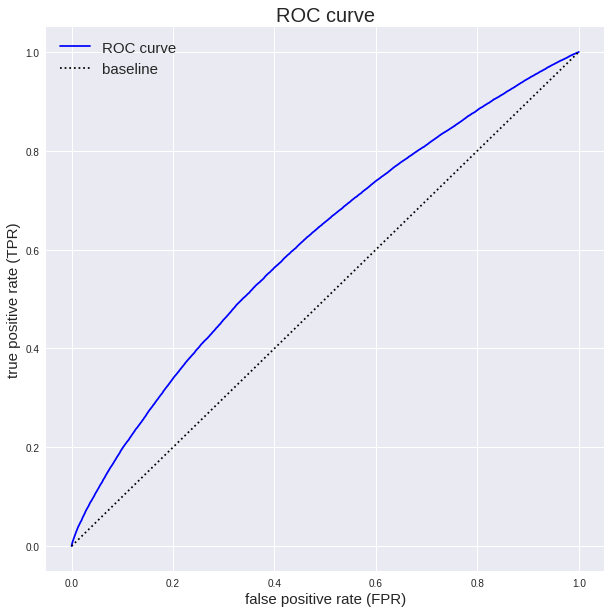

In [145]:
plotROC(fpr, tpr)

## 7.5 Dealing with imbalanced classes (undersampling)

In our data, 79% of flights were on time (class 0). Therefore, our model is biased towards predicting 0. We will now balance our training data so that it contains an equal amount of positive (1) and negative (0) samples. With this balanced set we fit a new classifier, and evaluate on the same test set.

Note that we balance our training set, but we still evaluate our model on the original test set so that the test

In [147]:
# category count before balancing
print("not delayed: {0}".format(np.sum(Y_train == 0)))
print("delayed: {0}".format(np.sum(Y_train == 1)))

not delayed: 1515803
delayed: 408435


In [0]:
# THIS IS THE ORIGINAL CODE FOR BALANCING THE CLASSES. READ AND UNDERSTAND IT FIRST.
# THE CELL BELOW PERFORMS THE SAME TASK, BUT IS MORE MEMORY-OPTIMIZED. 
# (memory is limited to about 12GB in Colaboratory).

# #split training data into classes
# X_train_1 = X_train[Y_train == 1]  #minority
# Y_train_1 = Y_train[Y_train == 1]

# X_train_0 = X_train[Y_train == 0]  #majority
# Y_train_0 = Y_train[Y_train == 0]

# X_train_0 = X_train_0[0:len(Y_train_1)]
# Y_train_0 = Y_train_0[0:len(Y_train_1)]

# #shapes should be equal
# print(X_train_1.shape, X_train_0.shape)
# print(Y_train_1.shape, Y_train_0.shape)

# X_train_balanced = pd.concat([X_train_1, X_train_0],axis=0)
# Y_train_balanced = pd.concat([Y_train_1, Y_train_0],axis=0)

# #shuffling first could improve training
# X_train_balanced, Y_train_balanced = sklearn.utils.shuffle(X_train_balanced, Y_train_balanced, random_state=0)

In [0]:
# balancing the classes in the train set, memory-optimized

l_1 = np.sum(Y_train == 1)


X_train = pd.concat([X_train[Y_train == 1], X_train[Y_train == 0][0:l_1]],axis=0)
Y_train = pd.concat([Y_train[Y_train == 1], Y_train[Y_train == 0][0:l_1]],axis=0)

X_train, Y_train = sklearn.utils.shuffle(X_train, Y_train, random_state=0)

In [149]:
# category count after balancing
print("not delayed: {0}".format(np.sum(Y_train == 0)))
print("delayed: {0}".format(np.sum(Y_train == 1)))

not delayed: 408435
delayed: 408435


Training a new model on balanced training set, and evaluate on the (non-balanced) test set.

In [150]:
model_logreg = LogisticRegression(random_state = 0)
model_logreg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
Y_test_prob = model_logreg.predict_proba(X_test)

In [152]:
auc = sklearn.metrics.roc_auc_score(Y_test,Y_test_prob[:,1])
auc

0.6600185707214967

With undersampling, our AUC score has improved slightly from 0.61 to 0.66.

It is important to mention that for a different random subset of the training data, or a different random test-train split, the results can be slightly different.

In [0]:
fpr, tpr, tresholds = sklearn.metrics.roc_curve(Y_test, Y_test_prob[:,1])

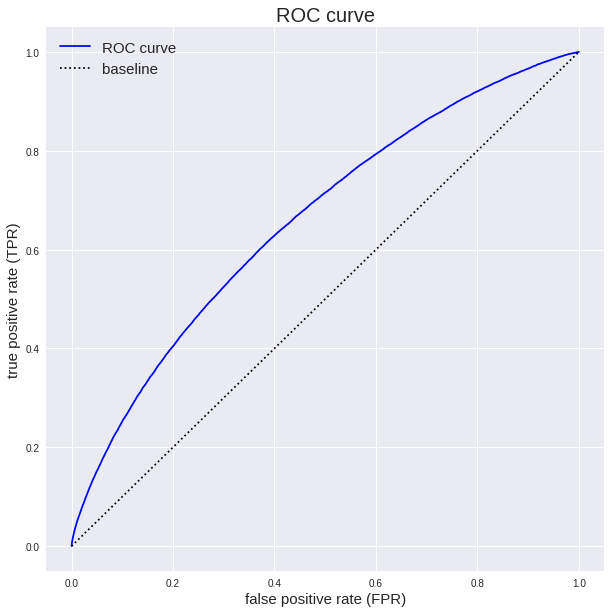

In [154]:
plotROC(fpr, tpr)

# 8 Decision tree classifier (to do)

First, run all cells of sections 1 up to (and including) 6

## 8.1 Building a first model

With a decision tree classifier, we can learn non-linear decision boundaries.
We keep the wind direction input. As a reminder, let's look at our final dataset.

In [2]:
delays = pd.read_csv("/content/drive/My Drive/xylosai/regression/FlightDelaysData_clean.csv",header=0,index_col = 0)
delays.head()

/usr/local/lib/python2.7/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,OriginAirportID,DestAirportID,ArrDel15,Carrier_0,Carrier_1,Carrier_2,Carrier_3,Carrier_4,Carrier_5,Carrier_6,...,DestAirportID_54,DestAirportID_55,DestAirportID_56,DestAirportID_57,DestAirportID_58,DestAirportID_59,DestAirportID_60,DestAirportID_61,DestAirportID_62,DestAirportID_63
0,11433,13303,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14869,12478,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14057,14869,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15016,11433,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,10397,15016,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
delays.columns

Index([u'OriginAirportID', u'DestAirportID', u'ArrDel15', u'Carrier_0',
       u'Carrier_1', u'Carrier_2', u'Carrier_3', u'Carrier_4', u'Carrier_5',
       u'Carrier_6',
       ...
       u'DestAirportID_54', u'DestAirportID_55', u'DestAirportID_56',
       u'DestAirportID_57', u'DestAirportID_58', u'DestAirportID_59',
       u'DestAirportID_60', u'DestAirportID_61', u'DestAirportID_62',
       u'DestAirportID_63'],
      dtype='object', length=181)

In [0]:
Y = delays["ArrDel15"].astype(np.float64).values
del delays["ArrDel15"]


In [0]:
X = delays.drop(columns=["ArrDel15"]).astype(np.float64).values

In [0]:
X_traindev, X_test, Y_traindev, Y_test = train_test_split(X,Y,random_state=0,test_size = 0.10)

del X
del Y


In [0]:
# balancing the classes in the train/dev set, memory-optimized

l_1 = np.sum(Y_traindev == 1)


X_traindev = pd.concat([X_traindev[Y_traindev == 1], X_traindev[Y_traindev == 0][0:l_1]],axis=0)
Y_traindev = pd.concat([Y_traindev[Y_traindev == 1], Y_traindev[Y_traindev == 0][0:l_1]],axis=0)

X_traindev, Y_traindev = sklearn.utils.shuffle(X_traindev, Y_traindev, random_state=0)



In [0]:
# category count in the train/dev set after balancing. Should be equal.
print("not delayed: {0}".format(np.sum(Y_traindev == 0)))
print("delayed: {0}".format(np.sum(Y_traindev == 1)))


In [0]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X_traindev,Y_traindev,random_state=0,test_size = 0.10)

In [0]:
clf = tree.DecisionTreeClassifier(random_state=0, min_samples_split = 1000)

In [0]:
start = time.time()
clf.fit(X_train, Y_train)
end = time.time()

seconds = end-start
print("Fitting took {0} seconds".format(seconds))

Fitting took 224.89454913139343 seconds


## 8.2 Evaluating our model

Let's first look at the predicted probabilities for our test set...

In [0]:
Y_log_prob = model_logreg.predict_proba(X_test)
Y_log_prob


array([[0.91938376, 0.08061624],
       [0.82355954, 0.17644046],
       [0.81050677, 0.18949323],
       ...,
       [0.84695215, 0.15304785],
       [0.84695215, 0.15304785],
       [0.66781361, 0.33218639]])

All probabilities are 0 or 1?


In [0]:
clf.tree_.node_count

17735

0.6448286481318811

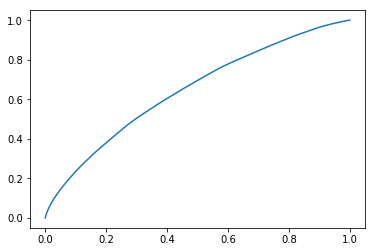

In [0]:
auc = sklearn.metrics.roc_auc_score(Y_test,Y_test_prob[:,1])
print(auc)

In [0]:
fpr, tpr, tresholds = sklearn.metrics.roc_curve(Y_test, Y_test_prob[:,1])

In [0]:
def plotROC(fpr, tpr):
  fig = plt.figure(figsize = (10,10))
  plt.xlabel("false positive rate (FPR)",fontsize = 15)
  plt.ylabel("true positive rate (TPR)",fontsize = 15)
  plt.title("ROC curve",fontsize=20)
  plt.plot(fpr, tpr,"b",fpr, fpr, "k:")
  plt.legend(("ROC curve","baseline"),fontsize=15)
  plt.show()

In [0]:
plotROC(fpr, tpr)


In the code above, we have not limited the growth of our tree in any way. As a result, the tree has kept making splits untill every node had zero impurities. The result is a tree that is overfitted on the data.

For decision trees, the growth of the tree must be limited to avoid overfitting. This can be done in multiple ways. In the next section we will limited the tree growth by:

1. Limiting the maximum depth of the tree
2. Setting a minimum a

## 4.2 Hyperparameter search

In [0]:
split_list = [2,500,1000,2000]
depth_list = [10,20,30,40]

2 / 10
2 / 20
2 / 30
2 / 40
500 / 10
500 / 20
500 / 30
500 / 40
1000 / 10
1000 / 20
1000 / 30
1000 / 40
2000 / 10
2000 / 20
2000 / 30
2000 / 40
{'run_6': {'auc_train': 0.7303856667732778, 'split': 500, 'depth': 30, 'auc_dev': 0.6748519463265837}, 'run_0': {'auc_train': 0.6527034329248941, 'split': 2, 'depth': 10, 'auc_dev': 0.6465847349996299}, 'run_3': {'auc_train': 0.9901079484713191, 'split': 2, 'depth': 40, 'auc_dev': 0.5793248062261067}, 'run_4': {'auc_train': 0.6514636524788621, 'split': 500, 'depth': 10, 'auc_dev': 0.646608779731869}, 'run_7': {'auc_train': 0.7391849252866118, 'split': 500, 'depth': 40, 'auc_dev': 0.6735938002712927}, 'run_12': {'auc_train': 0.6493058581458026, 'split': 2000, 'depth': 10, 'auc_dev': 0.6454488154198862}, 'run_11': {'auc_train': 0.712907419989401, 'split': 1000, 'depth': 40, 'auc_dev': 0.6739786028844735}, 'run_9': {'auc_train': 0.6937047403903195, 'split': 1000, 'depth': 20, 'auc_dev': 0.6719229531165309}, 'run_15': {'auc_train': 0.69278397533991

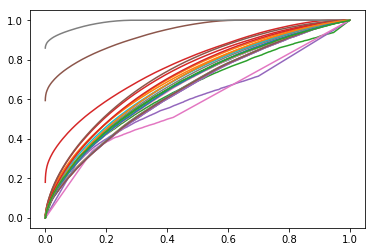

In [0]:
result_dict = {}
i = 0
optimal_results = {"split":split_list[0],"depth":depth_list[0],"auc_dev":0}
clf_best = None
for s in split_list:
    for d in depth_list:
        print(str(s)+" / "+str(d))
        clf = tree.DecisionTreeClassifier(random_state=0, min_samples_split = s,max_depth = d)
        clf.fit(X_train, Y_train)
        auc_dev = evaluate_clf(clf,X_dev,Y_dev,plot=False)
        if auc_dev > optimal_results["auc_dev"]:
            optimal_results["split"] = s
            optimal_results["depth"] = d
            optimal_results["auc_dev"] = auc_dev
            clf_best = clf
        auc_train = evaluate_clf(clf,X_train,Y_train,plot=False)
        result_dict["run_"+str(i)] = {"split":s,"depth":d,"auc_train":auc_train,"auc_dev":auc_dev}
        i += 1
        
print(result_dict)

optimal_results["auc_test"] = evaluate_clf(clf_best,X_test,Y_test,plot=False)



with open('result_decisiontreeCLF.txt','a') as f:
    f.write(json.dumps(result_dict,sort_keys=True,indent=4))
    f.write("Best results:")
    f.write(json.dumps(optimal_results,sort_keys=True,indent=4))
    

# 5 Dense neural network (to do)

In [0]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, Dropout, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import tensorflow as tf

Using TensorFlow backend.


In [0]:
def delayNNmodel(input_shape,hidden_units = [100,100],dropout_rate = 0.1):
    
    #input layer
    X_input = Input(input_shape)
    
    #first hidden layer
    X = Dense(hidden_units[0])(X_input)
    X = Activation('relu')(X)
    X = Dropout(dropout_rate,seed=0)(X)
    
    #next hidden layer(s)
    if len(hidden_units)>2:
        for n in hidden_units[1:]:
            X = Dense(n)(X)
            X = Activation('relu')(X)
            X = Dropout(dropout_rate,seed=0)(X)
    elif len(hidden_units) == 2:
        X = Dense(hidden_units[1])(X)
        X = Activation('relu')(X)
        X = Dropout(dropout_rate,seed=0)(X)
        
    #output layer
    X = Dense(1)(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name = 'delayBinaryClassifierNN')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
def evaluate_NN(model,X,Y,plot=False):
    Y_pred = model.predict(X)
    fpr,tpr,thresholds = roc_curve(Y,Y_pred)
    if plot:
        plt.plot(fpr,tpr)
    AUC = auc(fpr,tpr)
    return AUC

In [0]:
def fit_and_plot(model,X_train,Y_train,X_test,Y_test,epochs = 10,verbose=False,evaluate_offset = 0):
    auc_test = []
    auc_train = []
    for i in range(epochs):
        print(i)
        model.fit(X_train,Y_train,epochs=1,batch_size=128,verbose=0)
        if i >= evaluate_offset:
            auc_test_ = evaluate_NN(model,X_test,Y_test,plot=False)
            auc_test.append(auc_test_)
            auc_train_ = evaluate_NN(model,X_train,Y_train,plot=False)
            auc_train.append(auc_train_)
            if verbose:
                print("Epoch {2}. Test auc: {0}, Train auc: {1}".format(auc_test_,auc_train_,i))
    plt.figure()
    plt.plot(np.arange(len(auc_test)),auc_test,'r',np.arange(len(auc_train)),auc_train,'b')
    plt.show()
    return model

**never name the output of this function 'auc' since it collides with the name of the function auc, imported above**

auc_ = evaluate_NN(model,X_test,Y_test,plot=False)
print(auc_)

**Output is always 0, see cell below. Let's try to balance to dataset first, since it is skewed towards output 0**

In [0]:
pred=model.predict(X_train)
np.sum(pred>0.00001)

0

In [0]:
np.sum(Y_train==1)/Y_train.shape[0]

0.21225804708149407

In [0]:
np.sum(Y_train==0)/Y_train.shape[0]

0.7877419529185059

In [0]:
#turn this into a robust reusable function!

index_0 = (Y_train==0)
index_1 = (Y_train==1)
print(np.sum(index_0))
print(np.sum(index_1))
amt_1 = np.sum(index_1)
Y_train_0 = Y_train[index_0]
Y_train_1 = Y_train[index_1]
X_train_0 = X_train[index_0]
X_train_1= X_train[index_1]

np.random.seed(0)
selection_0 = np.random.randint(0,Y_train_0.shape[0],amt_1)

Y_train_0_selected = Y_train_0[selection_0]
X_train_0_selected = X_train_0[selection_0]

X_train_balanced = np.append(X_train_0_selected,X_train_1,axis=0)
Y_train_balanced = np.append(Y_train_0_selected,Y_train_1,axis=0)

print(X_train_balanced.shape)
print(np.expand_dims(Y_train_balanced,axis=1).shape)

XY = np.append(X_train_balanced,np.expand_dims(Y_train_balanced,axis=1),axis=1)
np.random.shuffle(XY)
X_train_balanced = XY[:,0:-1]
Y_train_balanced = XY[:,-1]

print(X_train_balanced.shape)
print(Y_train_balanced.shape)

1515803
408435
(816870, 200)
(816870, 1)
(816870, 200)
(816870,)


Epoch 1/1
816870/816870 [==============================] - 11s 14us/step - loss: 0.7072 - acc: 0.5774
Epoch 0. Test auc: 0.6502808914769697, Train auc: 0.6470881794865477
Epoch 1/1
816870/816870 [==============================] - 11s 13us/step - loss: 0.6635 - acc: 0.5989
Epoch 1. Test auc: 0.6546190910458762, Train auc: 0.6532343825949037
Epoch 1/1
816870/816870 [==============================] - 11s 13us/step - loss: 0.6590 - acc: 0.6052
Epoch 2. Test auc: 0.6574285401007209, Train auc: 0.655030532673549


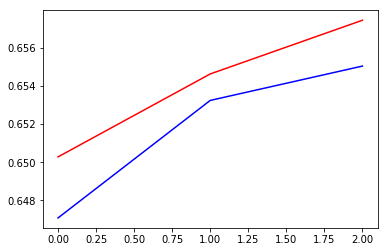

In [0]:
input_shape = [X_train.shape[1]]
model = delayNNmodel(input_shape,dropout_rate=0)
fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=True,epochs=3)

In [0]:
auc_ = evaluate_NN(model,X_test,Y_test,plot=False)
print(auc_)

0.6561154672356233


units: [128, 128], dropout: 0
0
1
2
3
4
5


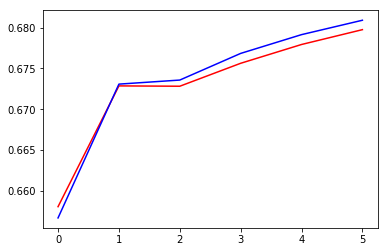

units: [128, 128], dropout: 0.05
0
1
2
3
4
5


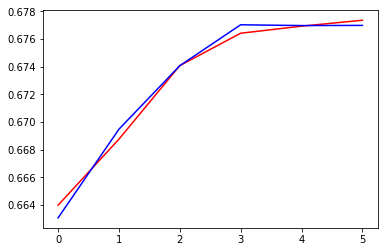

units: [128, 128], dropout: 0.1
0
1
2
3
4
5


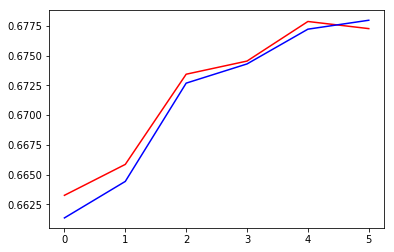

units: [128, 128], dropout: 0.2
0
1
2
3
4
5


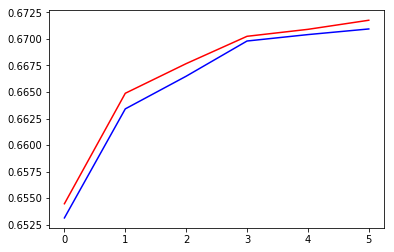

units: [128, 128, 128], dropout: 0
0
1
2
3
4
5


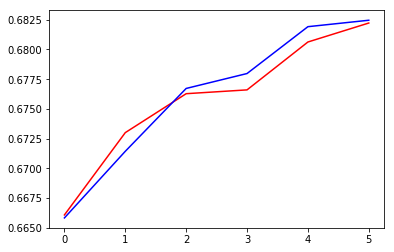

units: [128, 128, 128], dropout: 0.05
0
1
2
3
4
5


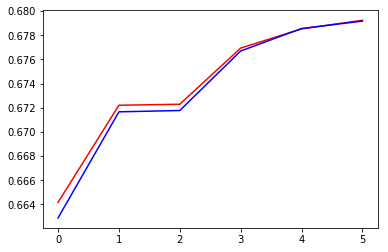

units: [128, 128, 128], dropout: 0.1
0
1
2
3
4
5


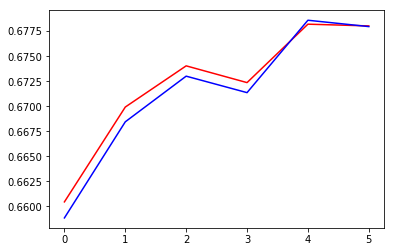

units: [128, 128, 128], dropout: 0.2
0
1
2
3
4
5


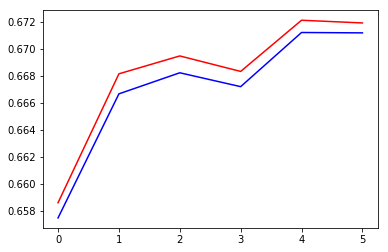

units: [256, 256, 128], dropout: 0
0
1
2
3
4
5


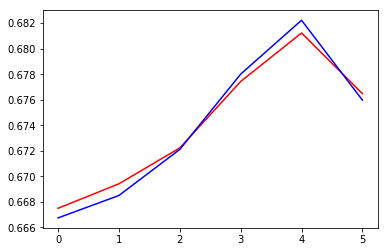

units: [256, 256, 128], dropout: 0.05
0
1
2
3
4
5


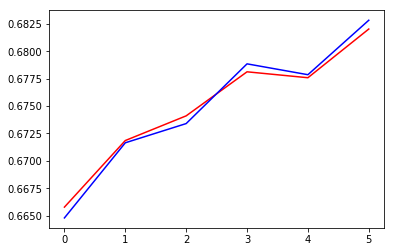

units: [256, 256, 128], dropout: 0.1
0
1
2
3
4
5


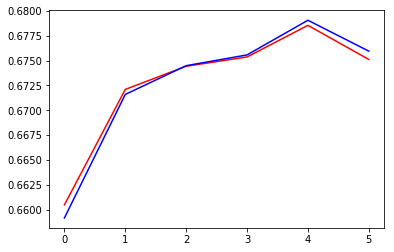

units: [256, 256, 128], dropout: 0.2
0
1
2
3
4
5


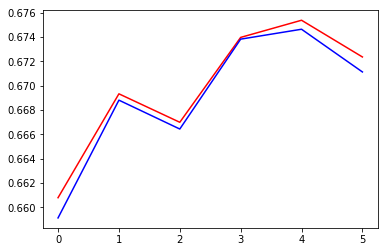

In [0]:
units = [[128,128],[128,128,128],[256,256,128]]
dropout_rates = [0,0.05,0.1,0.2]
for u in units:
    for dropout_rate in dropout_rates:
        model = delayNNmodel(input_shape, hidden_units = u, dropout_rate = dropout_rate)
        print("units: {0}, dropout: {1}".format(u,dropout_rate))
        fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=False,epochs=6)

**doing extra epochs for those who seem promising**

units: [128, 128], dropout: 0
0
1
2
3
4
5
6
7
8
9


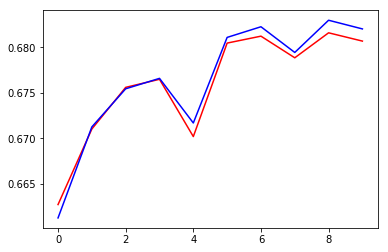

units: [128, 128, 128], dropout: 0
0
1
2
3
4
5
6
7
8
9


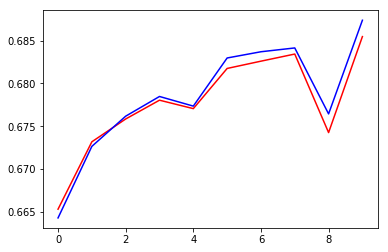

units: [128, 128, 128], dropout: 0.05
0
1
2
3
4
5
6
7
8
9


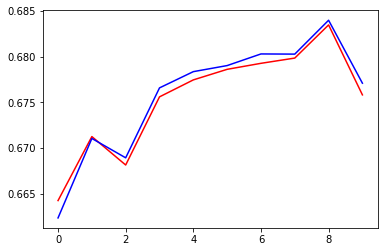

units: [256, 256, 128], dropout: 0.05
0
1
2
3
4
5
6
7
8
9


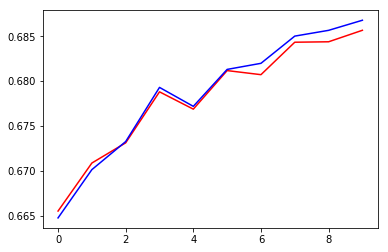

In [0]:
units = [[128,128],[128,128,128],[128,128,128],[256,256,128]]
dropout_rates = [0,0,0.05,0.05]
for u,dropout_rate in zip(units,dropout_rates):
        model = delayNNmodel(input_shape, hidden_units = u, dropout_rate = dropout_rate)
        print("units: {0}, dropout: {1}".format(u,dropout_rate))
        fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=False,epochs=10)

units: [128, 128, 128], dropout: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


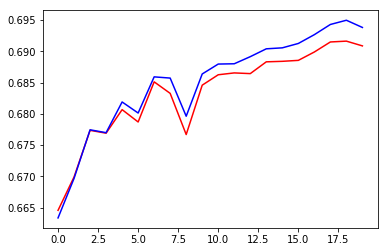

units: [256, 256, 128], dropout: 0.05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


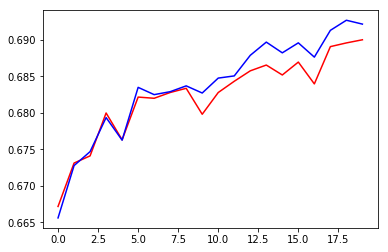

In [0]:
units = [[128,128,128],[256,256,128]]
dropout_rates = [0,0.05]
for u,dropout_rate in zip(units,dropout_rates):
        model = delayNNmodel(input_shape, hidden_units = u, dropout_rate = dropout_rate)
        print("units: {0}, dropout: {1}".format(u,dropout_rate))
        fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=False,epochs=20)

units: [256, 256, 128], dropout: 0.05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


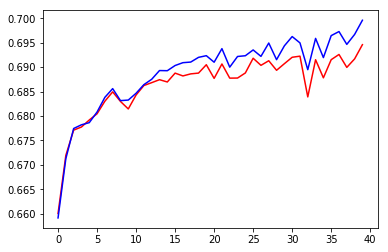

In [0]:
units = [[256,256,128]]
dropout_rates = [0.05]
for u,dropout_rate in zip(units,dropout_rates):
        model = delayNNmodel(input_shape, hidden_units = u, dropout_rate = dropout_rate)
        print("units: {0}, dropout: {1}".format(u,dropout_rate))
        fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=False,epochs=40)

units: [256, 256, 128], dropout: 0.05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


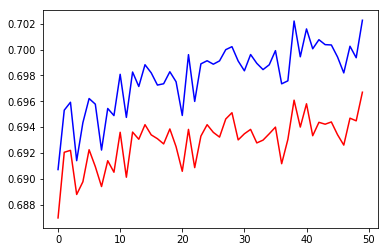

In [0]:
units = [[256,256,128]]
input_shape = [X_train.shape[1]]
dropout_rates = [0.05]
for u,dropout_rate in zip(units,dropout_rates):
        model = delayNNmodel(input_shape, hidden_units = u, dropout_rate = dropout_rate)
        print("units: {0}, dropout: {1}".format(u,dropout_rate))
        fitted_model = fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=False,epochs=80,
                                    evaluate_offset=30)